## Business problem/objective: Factors driving credit card spend / Predicting Credit limit

### Approach for the problem: Linear Regression to predict the credit card limit for new applicants

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor 
from xgboost.sklearn import XGBRegressor #pip install xgboost
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import metrics
from scipy.stats import stats
from patsy import dmatrices
import itertools

In [2]:
data = pd.read_csv("Data Set.csv")
data_dict = pd.read_csv('Data Dictionary.csv')

In [3]:
data.head(10)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1.0,2.00,1.0,20.0,2.0,September,15.0,3.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0648-AIPJSP-UVM,5.0,5.00,0.0,22.0,2.0,May,17.0,4.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,5195-TLUDJE-HVO,3.0,4.00,1.0,67.0,6.0,June,14.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4459-VLPQUH-3OL,4.0,3.00,0.0,23.0,2.0,May,16.0,3.0,2.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,8158-SMTQFB-CNO,2.0,2.00,0.0,26.0,3.0,July,16.0,3.0,2.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,9662-FUSYIM-1IV,4.0,4.00,0.0,64.0,5.0,August,17.0,4.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,7432-QKQFJJ-K72,2.0,5.00,1.0,52.0,5.0,July,14.0,2.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8959-RZWRHU-ST8,3.0,4.00,1.0,44.0,4.0,October,16.0,3.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,9124-DZALHM-S6I,2.0,3.00,1.0,66.0,6.0,October,12.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,3512-MUWBGY-52X,2.0,2.00,0.0,47.0,4.0,July,11.0,1.0,6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#profile_report = pandas_profiling.ProfileReport(data)
#profile_report.to_file('Credit_profiling.html')

#### Below are the findings as per the pandas_profiling report:

* There are no missing values in the data.
* There are no duplicate rows.
* Average Amount spent on primary card last month is 337.20.
* Average Amount spent on secondary card last month is 160.87.
* There are 179 or 3.6% zeroes in Amount spent on secondary card last month.

#### Splitting Categorical and Numerical variables as per Data Dictionary excel sheet

In [5]:
data_dict.head()

,Numeric Variable,Label,Unnamed: 2,Categorical Variable,Unnamed: 4,Label.1
0,custid,Customer ID,NaN,region,1,Zone 1
1,region,Geographic indicator,NaN,NaN,2,Zone 2
2,townsize,Size of hometown,NaN,NaN,3,Zone 3
3,gender,Gender,NaN,NaN,4,Zone 4
4,age,Age in years,NaN,NaN,5,Zone 5


In [6]:
data_dict.columns

Index(['Numeric Variable', 'Label', 'Unnamed: 2', 'Categorical Variable',
       'Unnamed: 4', 'Label.1'],
      dtype='object')

In [7]:
data_dict.drop(['Label', 'Unnamed: 2',
       'Unnamed: 4', 'Label.1'], axis = 1, inplace = True)

In [8]:
data_dict_cat = data_dict.copy(deep = True)
data_dict_cat.drop(['Numeric Variable'], axis = 1, inplace = True)
data_dict.drop(['Categorical Variable'], axis = 1, inplace = True)

In [9]:
data_dict_cat.dropna(inplace = True)
data_dict.dropna(inplace = True)

In [10]:
Cat_Var = data_dict_cat['Categorical Variable'].to_list()
Num_Var = data.columns.to_list()

In [11]:
num_col = list(set(Num_Var)-set(Cat_Var))#extracting numerical features

print(">>Total Columns:",data.shape[1])
Cat_Var.sort()
num_col.sort()

print("-"*50)
print("\t categorical columns: ",len(Cat_Var))
print("-"*50)
print(Cat_Var)

print("\n","-"*50)
print("\t continuous columns: ",len(num_col))
print("-"*50)
print(num_col)

>>Total Columns: 130
--------------------------------------------------
	 categorical columns:  84
--------------------------------------------------
['active', 'address', 'addresscat', 'agecat', 'bfast', 'birthmonth', 'callcard', 'callid', 'callwait', 'carbought', 'carbuy', 'carcatvalue', 'card', 'card2', 'card2benefit', 'card2fee', 'card2tenure', 'card2tenurecat', 'card2type', 'cardbenefit', 'cardfee', 'cardtenure', 'cardtenurecat', 'cardtype', 'carown', 'cars', 'cartype', 'churn', 'commute', 'commutebike', 'commutebus', 'commutecar', 'commutecarpool', 'commutecat', 'commutemotorcycle', 'commutenonmotor', 'commutepublic', 'commuterail', 'commutewalk', 'confer', 'default', 'ebill', 'edcat', 'empcat', 'employ', 'equip', 'forward', 'gender', 'homeown', 'hometype', 'inccat', 'internet', 'jobcat', 'jobsat', 'marital', 'multline', 'news', 'owncd', 'owndvd', 'ownfax', 'owngame', 'ownipod', 'ownpc', 'ownpda', 'owntv', 'ownvcr', 'pager', 'polcontrib', 'polparty', 'polview', 'reason', 'region'

In [12]:
data_cat = data[Cat_Var]
data_num = data[num_col]

In [13]:
data_cat.head()

,active,address,addresscat,agecat,bfast,birthmonth,callcard,callid,callwait,carbought,...,response_03,retire,spousedcat,telecommute,tollfree,townsize,union,voice,vote,wireless
0,0.0,0.0,1.0,2.0,3.0,September,1.0,0.0,1.0,0.0,...,0.0,0.0,-1.0,0.0,1.0,2.00,1.0,1.0,1.0,0.0
1,1.0,2.0,1.0,2.0,1.0,May,1.0,1.0,0.0,0.0,...,0.0,0.0,-1.0,1.0,0.0,5.00,0.0,1.0,0.0,1.0
2,0.0,30.0,5.0,6.0,3.0,June,1.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,4.00,0.0,0.0,0.0,0.0
3,1.0,3.0,2.0,2.0,1.0,May,1.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,3.00,0.0,0.0,0.0,0.0
4,1.0,3.0,2.0,3.0,3.0,July,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,0.0,1.0,2.00,0.0,1.0,0.0,1.0


In [14]:
data_num.head()

,age,card2spent,cardmon,cardspent,cardten,carvalue,commutetime,creddebt,custid,debtinc,...,pets_reptiles,pets_saltfish,pets_small,reside,spoused,tenure,tollmon,tollten,wiremon,wireten
0,20.0,67.80,14.25,81.66,60.00,14.3,22.00,1.20,3964-QJWTRG-NPN,11.1,...,0.0,0.0,0.0,3.0,-1.0,5.0,29.0,161.05,0.00,0.00
1,22.0,34.94,16.00,42.60,610.00,6.8,29.00,1.22,0648-AIPJSP-UVM,18.6,...,0.0,0.0,0.0,2.0,-1.0,39.0,0.0,0.00,45.65,1683.55
2,67.0,175.75,23.00,184.22,1410.00,18.8,24.00,0.93,5195-TLUDJE-HVO,9.9,...,0.0,0.0,0.0,3.0,13.0,65.0,0.0,0.00,0.00,0.00
3,23.0,18.42,21.00,340.99,685.00,8.7,38.00,0.02,4459-VLPQUH-3OL,5.7,...,0.0,0.0,0.0,5.0,18.0,36.0,0.0,0.00,0.00,0.00
4,26.0,252.73,17.25,255.10,360.00,10.6,32.00,0.21,8158-SMTQFB-CNO,1.7,...,0.0,0.0,0.0,4.0,13.0,21.0,16.5,387.70,19.05,410.80


### Data preparation

In [15]:
data_num['Total_spent'] = data_num['cardspent'] + data_num['card2spent']
data_num.drop(['cardspent', 'card2spent'], axis = 1, inplace = True)

In [16]:
#custid variable is dropped as the same is not required

data_num.drop('custid', axis = 1,inplace = True)

In [17]:
# removing variables card1items and card2items as they are directly proportional to spend

#data_num.drop(['carditems', 'card2items'], axis = 1, inplace = True) #both columns were not in Data Set sheet

#removing log variables as not required

data_num.drop(["lninc","lncreddebt","lnothdebt","lnlongmon","lnlongten","lntollmon","lntollten","lnequipmon","lnequipten","lncardmon","lncardten","lnwiremon","lnwireten"], axis = 1, inplace = True)

In [18]:
#changing data type to float, for outlier treatment

data_num.select_dtypes(include=['O'])

,cardten,commutetime,longten
0,60.00,22.00,34.40
1,610.00,29.00,330.60
2,1410.00,24.00,1858.35
3,685.00,38.00,199.45
4,360.00,32.00,74.10
...,...,...,...
4995,1565,21,2405.9
4996,800,26,289
4997,1070,32,2109.25
4998,345,12,282.7


In [19]:
for x in ['cardten', 'commutetime', 'longten']:
    data_num[x] = pd.to_numeric(data_num[x], errors='coerce')

In [20]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             5000 non-null   float64
 1   cardmon         5000 non-null   float64
 2   cardten         4998 non-null   float64
 3   carvalue        5000 non-null   float64
 4   commutetime     4998 non-null   float64
 5   creddebt        5000 non-null   float64
 6   debtinc         5000 non-null   float64
 7   ed              5000 non-null   float64
 8   equipmon        5000 non-null   float64
 9   equipten        5000 non-null   float64
 10  hourstv         5000 non-null   float64
 11  income          5000 non-null   float64
 12  longmon         5000 non-null   float64
 13  longten         4997 non-null   float64
 14  othdebt         5000 non-null   float64
 15  pets            5000 non-null   float64
 16  pets_birds      5000 non-null   float64
 17  pets_cats       5000 non-null   f

In [21]:
# 'birthmonth' column 

from time import strptime
def tomonth(month_name):
    month_number=strptime(month_name, '%B').tm_mon
    return month_number

data_cat['birthmonth']=data_cat['birthmonth'].map(lambda x: tomonth(x))

In [22]:
data_cat['townsize'] = pd.to_numeric(data_cat['townsize'], errors='coerce')

In [23]:
# Treating Missing values
def missing_values(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
         x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode()[0])
    return x

data_num = data_num.apply(missing_values)
data_cat = data_cat.apply(missing_values)

In [24]:
#Outlier treatment
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

#Implementing outlier function 
data_num = data_num.apply(outlier_capping)

In [25]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             5000 non-null   float64
 1   cardmon         5000 non-null   float64
 2   cardten         5000 non-null   float64
 3   carvalue        5000 non-null   float64
 4   commutetime     5000 non-null   float64
 5   creddebt        5000 non-null   float64
 6   debtinc         5000 non-null   float64
 7   ed              5000 non-null   float64
 8   equipmon        5000 non-null   float64
 9   equipten        5000 non-null   float64
 10  hourstv         5000 non-null   float64
 11  income          5000 non-null   float64
 12  longmon         5000 non-null   float64
 13  longten         5000 non-null   float64
 14  othdebt         5000 non-null   float64
 15  pets            5000 non-null   float64
 16  pets_birds      5000 non-null   float64
 17  pets_cats       5000 non-null   f

In [26]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active             5000 non-null   float64
 1   address            5000 non-null   float64
 2   addresscat         5000 non-null   float64
 3   agecat             5000 non-null   float64
 4   bfast              5000 non-null   float64
 5   birthmonth         5000 non-null   int64  
 6   callcard           5000 non-null   float64
 7   callid             5000 non-null   float64
 8   callwait           5000 non-null   float64
 9   carbought          5000 non-null   float64
 10  carbuy             5000 non-null   float64
 11  carcatvalue        5000 non-null   float64
 12  card               5000 non-null   float64
 13  card2              5000 non-null   float64
 14  card2benefit       5000 non-null   float64
 15  card2fee           5000 non-null   float64
 16  card2tenure        5000 

#### Data analysis -> Univariate analysis

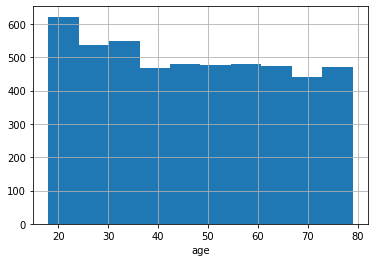

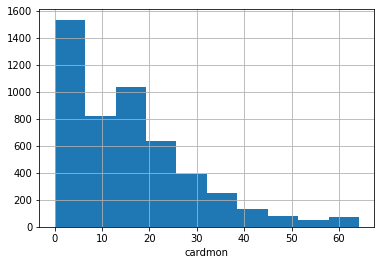

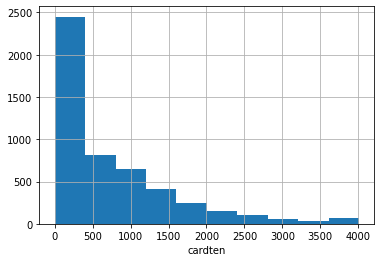

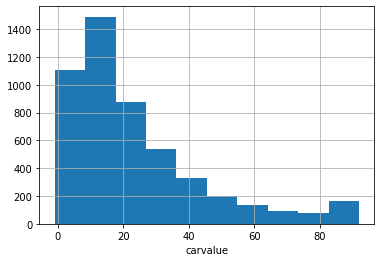

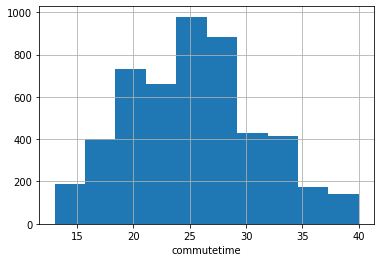

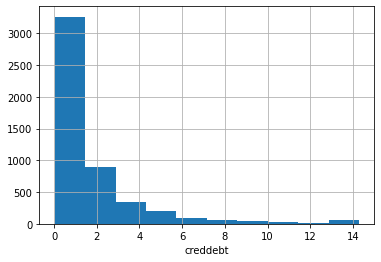

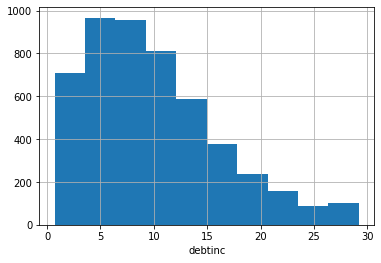

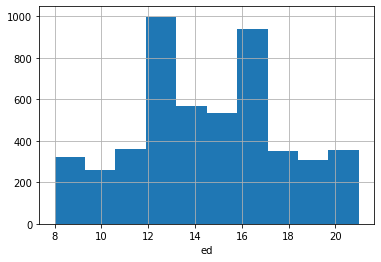

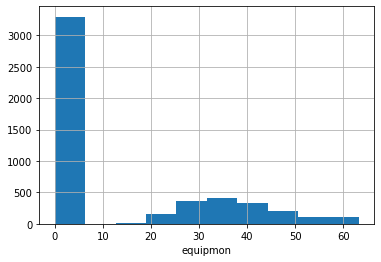

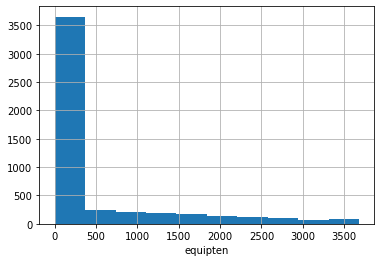

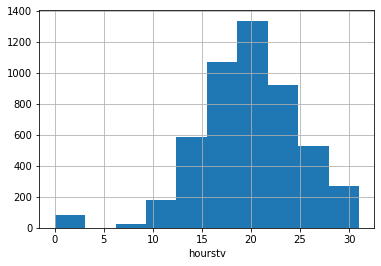

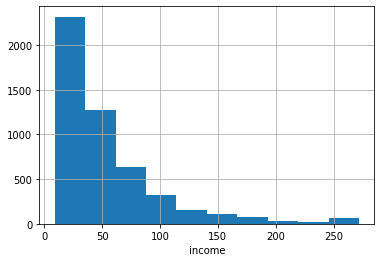

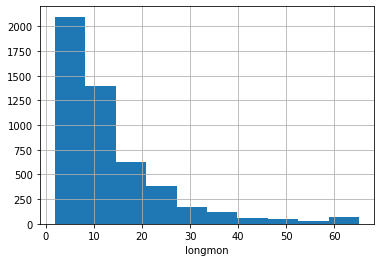

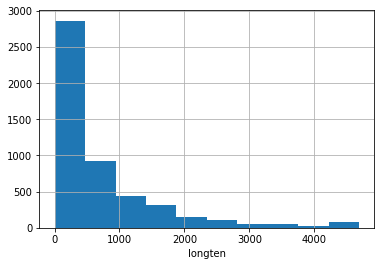

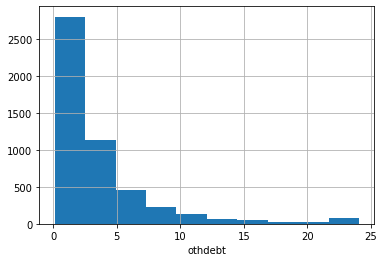

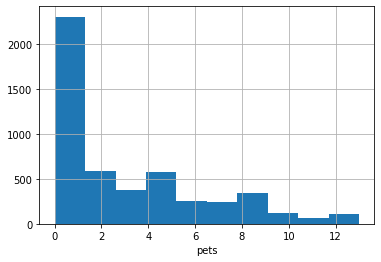

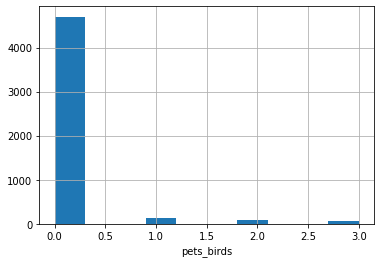

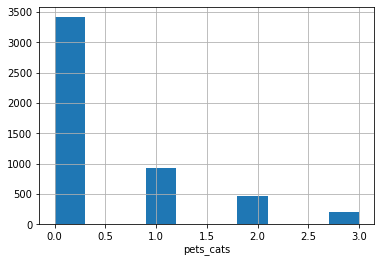

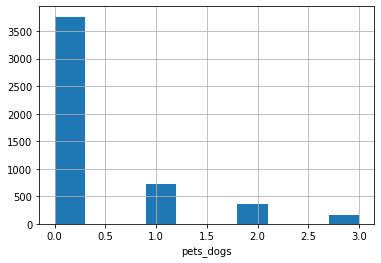

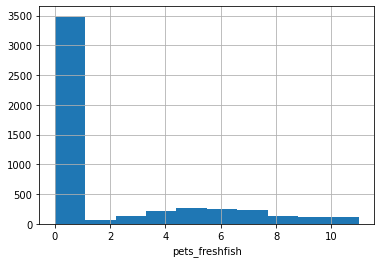

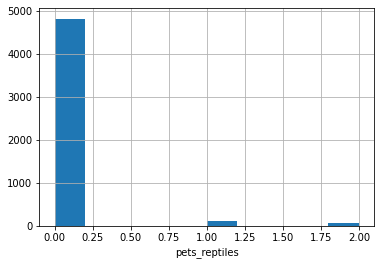

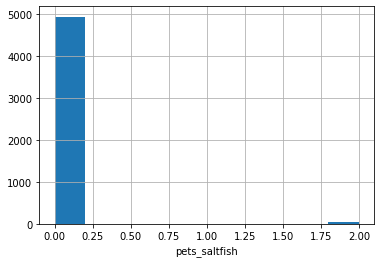

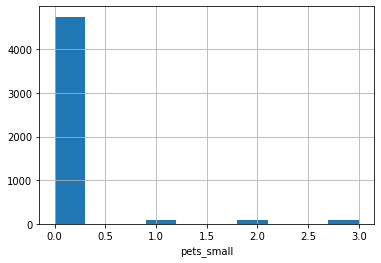

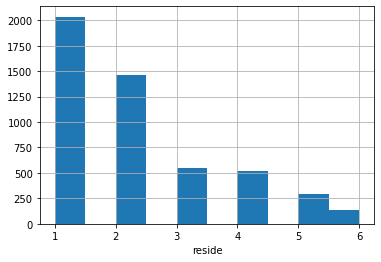

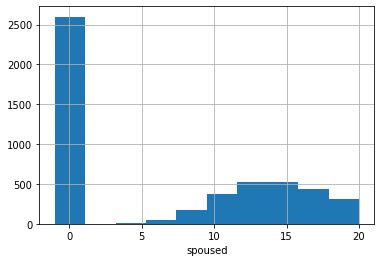

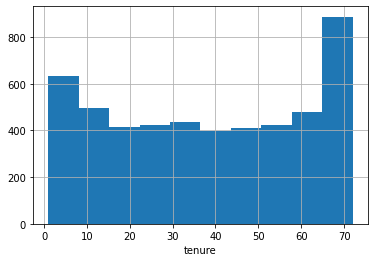

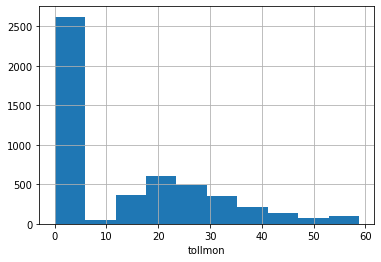

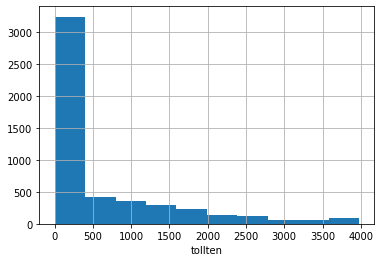

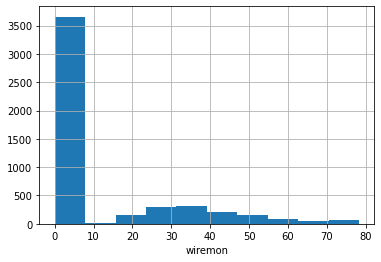

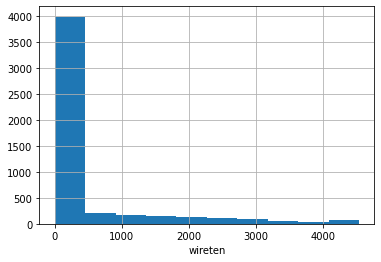

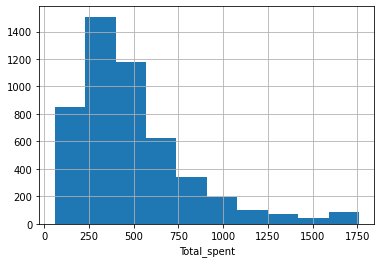

In [27]:
for x in data_num.columns:
    data_num[x].hist()
    plt.xlabel(str(x))
    plt.show()

In [28]:
# insights from the above plots

# Most of the variables follow exponential distribution.
# Age variable is following uniform distribution
# Ed (Years of education) following normal distribution

#### Data Analysis - Bi-variate analysis

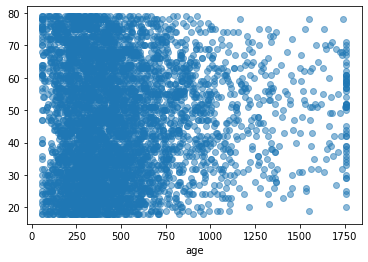

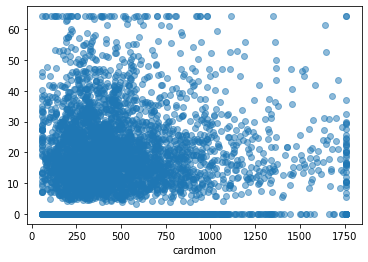

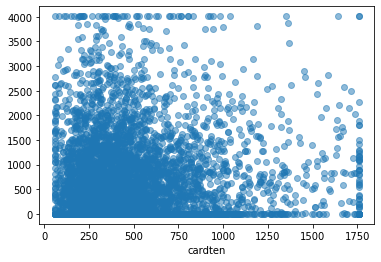

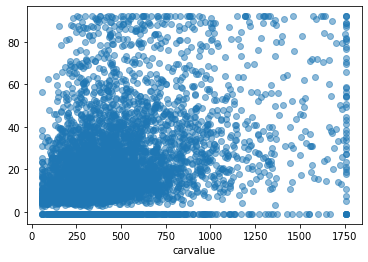

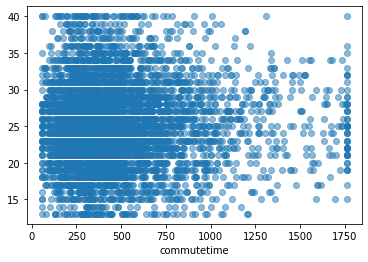

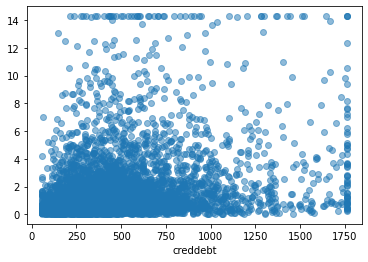

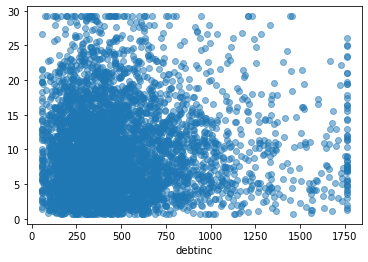

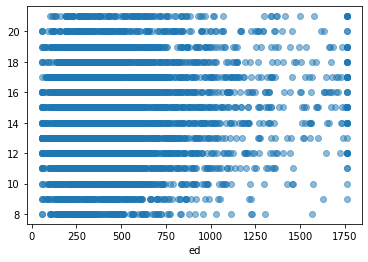

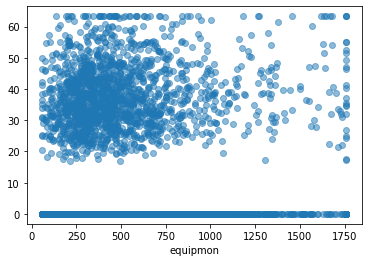

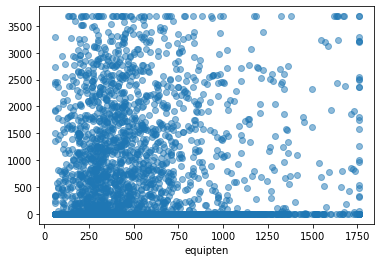

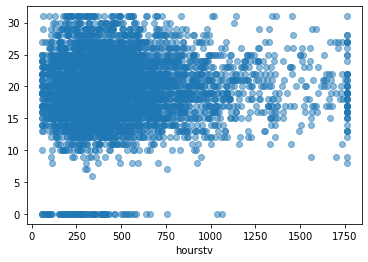

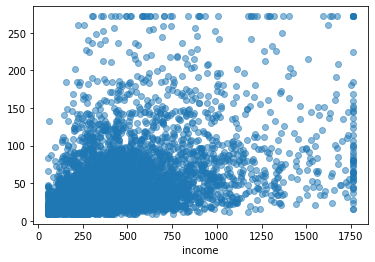

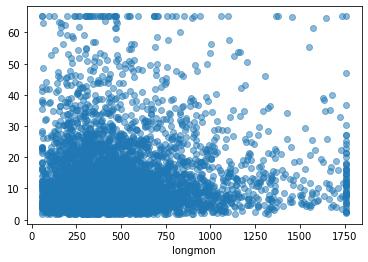

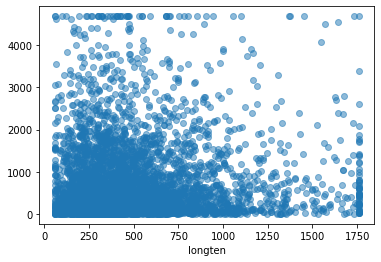

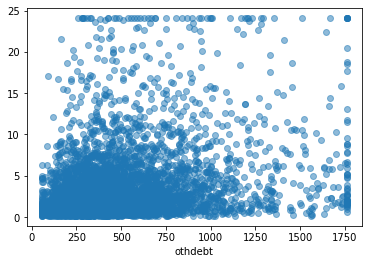

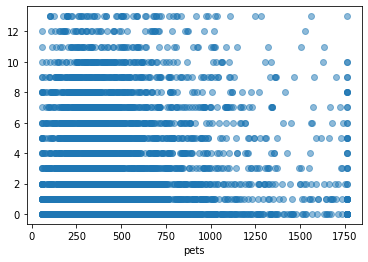

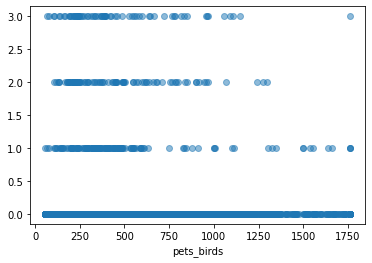

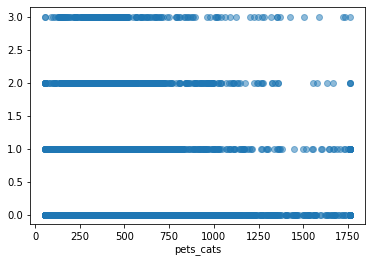

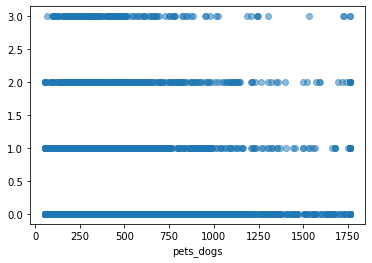

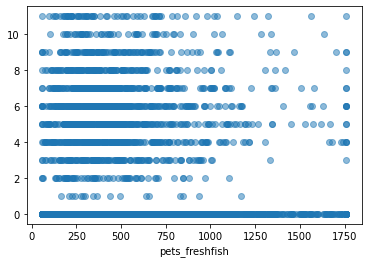

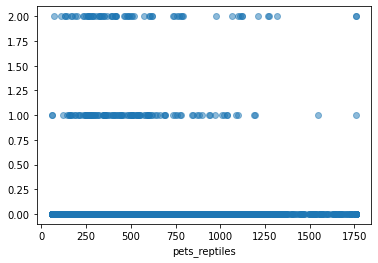

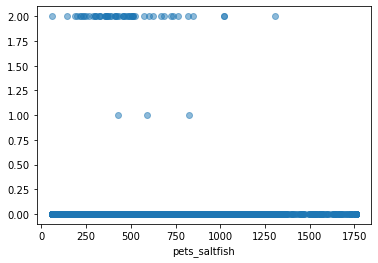

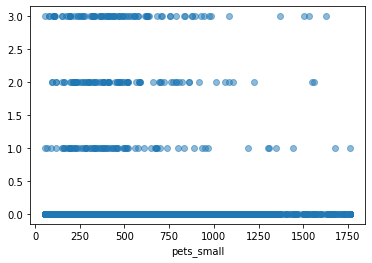

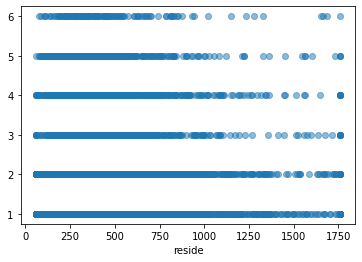

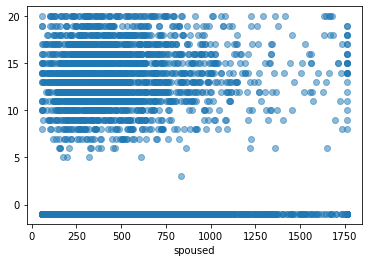

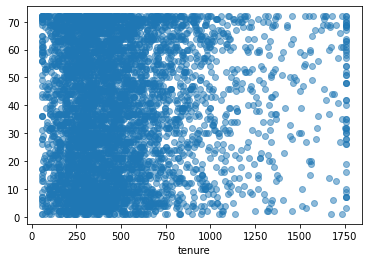

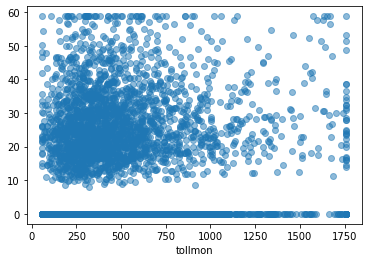

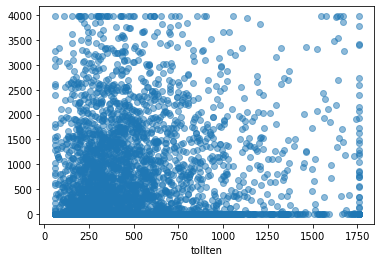

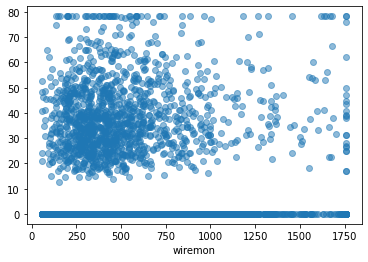

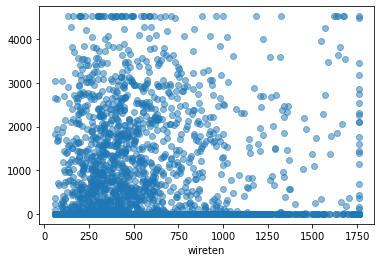

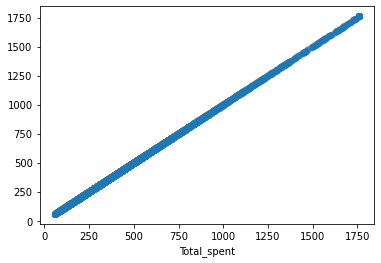

In [29]:
for i in data_num.columns:
    plt.scatter(data_num.Total_spent,data_num[i], alpha=0.5)
    plt.xlabel(str(i))
    plt.show()

#### Data Audit report

In [30]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary = data_num.apply(lambda x: var_summary(x)).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,2.351280e+05,47.025600,47.00,17.770338,315.784902,18.0000,18.000000,20.0000,23.000,31.0000,47.00,62.0000,72.000,76.0000,79.000000,79.0000
cardmon,5000.0,0.0,7.633475e+04,15.266950,13.75,14.156339,200.401931,0.0000,0.000000,0.0000,0.000,0.0000,13.75,22.7500,34.000,42.0000,64.250000,64.2500
cardten,5000.0,0.0,3.536182e+06,707.236391,425.00,848.139057,719339.860708,0.0000,0.000000,0.0000,0.000,0.0000,425.00,1080.0000,1870.500,2455.2500,4010.004000,4010.4000
carvalue,5000.0,0.0,1.160111e+05,23.202230,17.00,21.129844,446.470311,-1.0000,-1.000000,-1.0000,2.490,9.2000,17.00,31.1000,52.910,72.0000,92.000010,92.0010
commutetime,5000.0,0.0,1.266602e+05,25.332038,25.00,5.754200,33.110822,13.0000,13.000000,16.0000,18.000,21.0000,25.00,29.0000,33.000,35.0000,40.000100,40.0100
creddebt,5000.0,0.0,8.791860e+03,1.758372,0.93,2.380783,5.668128,0.0300,0.030000,0.1000,0.180,0.3900,0.93,2.0600,4.300,6.3715,14.280004,14.2804
debtinc,5000.0,0.0,4.957060e+04,9.914120,8.80,6.241691,38.958700,0.7000,0.700000,1.9000,2.800,5.1000,8.80,13.6000,18.600,22.2000,29.200000,29.2000
ed,5000.0,0.0,7.272100e+04,14.544200,14.00,3.242553,10.514149,8.0000,8.000000,9.0000,10.000,12.0000,14.00,17.0000,19.000,20.0000,21.000000,21.0000
equipmon,5000.0,0.0,6.454358e+04,12.908715,0.00,18.955975,359.328975,0.0000,0.000000,0.0000,0.000,0.0000,0.00,30.8000,42.700,49.0525,63.300005,63.3005
equipten,5000.0,0.0,2.316992e+06,463.398395,0.00,882.832804,779393.759638,0.0000,0.000000,0.0000,0.000,0.0000,0.00,510.1625,1912.325,2600.9900,3679.450075,3679.4575


In [31]:
cat_col_bool=[]

for col in data_cat:
    if set(data_cat[col].unique())=={0,1}: 
        cat_col_bool.append(col)
        
cat_col_dummy=list(set(data_cat)-set(cat_col_bool))

In [32]:
#Creating dummies for nominal categorical variables
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

for c_feature in cat_col_dummy:
    data_cat[c_feature] = data_cat[c_feature].astype('category')
    data_cat = create_dummies(data_cat , c_feature )

In [33]:
#Combining both categorical and Continuous data
data_final = pd.concat([data_num,data_cat],axis=1)

In [34]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 388 entries, age to empcat_5.0
dtypes: float64(80), uint8(308)
memory usage: 4.5 MB


In [35]:
# Looking at the assumptions - Linearity
corr_mat = data_final.corr()

In [36]:
corr_mat['abs_Total_spent'] = np.absolute(corr_mat['Total_spent'])

In [37]:
corr_mat[corr_mat['abs_Total_spent'] > 0.5]

,age,cardmon,cardten,carvalue,commutetime,creddebt,debtinc,ed,equipmon,equipten,...,townsize_2.0,townsize_2.6872749099639854,townsize_3.0,townsize_4.0,townsize_5.0,empcat_2.0,empcat_3.0,empcat_4.0,empcat_5.0,abs_Total_spent
Total_spent,0.03168,0.032661,0.048369,0.319367,-0.002715,0.248527,0.015066,0.100943,0.071432,0.088136,...,0.013887,-0.012138,-0.00858,-0.008732,-0.00071,-0.02619,0.011076,0.035594,0.079604,1.0


#### All X variables have low to moderate correlation with Y variable

<AxesSubplot:>

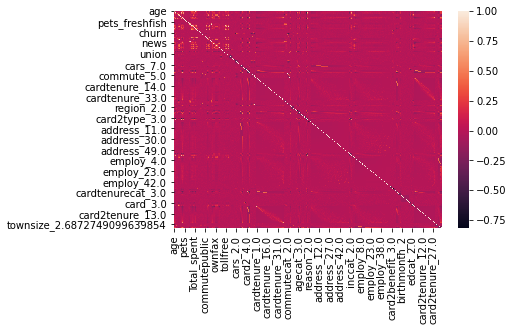

In [38]:
sns.heatmap(data_final.corr())

### Assumptions check

#### Y variable should follow normal distribution

<AxesSubplot:xlabel='Total_spent', ylabel='Density'>

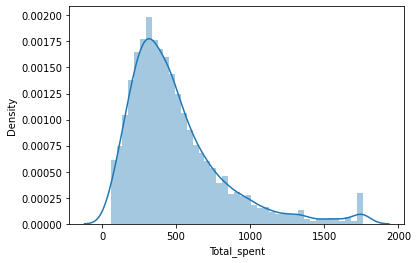

In [39]:
sns.distplot(data_final.Total_spent)

<AxesSubplot:xlabel='log_Total_spent', ylabel='Density'>

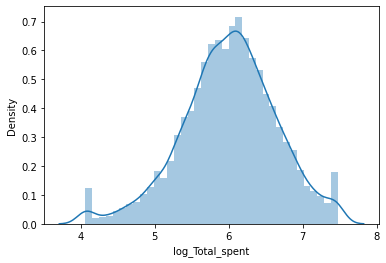

In [40]:
#as data is skewed, converting the same so it follows normal distribution

data_final['log_Total_spent'] = np.log(data_final.Total_spent)

data_final.drop('Total_spent', axis = 1,inplace = True)

sns.distplot(data_final.log_Total_spent)

### Feature reduction (resolve Multi-collinearity)

In [41]:
features = data_final[data_final.columns.difference( ['log_Total_spent'] )]
target = data_final['log_Total_spent']

#### 1. F- Regression

In [42]:
#F-Regression # Feature Selection based on importance
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression(  features, target )

In [43]:
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features.columns, F_values,  ['%.3f' % p for p in p_values])]

f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])

f_reg_results.sort_values(by=['F_Value'], ascending=False)

,Variable,F_Value,P_Value
306,income,724.662085,0.000
202,carvalue,519.265495,0.000
85,carcatvalue_1.0,436.617805,0.000
325,othdebt,363.679726,0.000
87,carcatvalue_3.0,362.711396,0.000
...,...,...,...
172,cardtenure_36.0,0.000068,0.993
379,townsize_4.0,0.000062,0.994
112,card2tenure_24.0,0.000041,0.995
68,birthmonth_10,0.000024,0.996


In [44]:
X = f_reg_results[f_reg_results['P_Value'] <= '0.05'].sort_values(by='F_Value', ascending = False).head(50)

In [45]:
X

,Variable,F_Value,P_Value
306,income,724.662085,0.000
202,carvalue,519.265495,0.000
85,carcatvalue_1.0,436.617805,0.000
325,othdebt,363.679726,0.000
87,carcatvalue_3.0,362.711396,0.000
228,creddebt,287.836916,0.000
305,inccat_5.0,261.047066,0.000
364,retire,204.476976,0.000
304,inccat_4.0,158.231495,0.000
327,owndvd,138.282716,0.000


In [46]:
#X.to_csv('forvif.csv')

#### 2. VIF

In [127]:
Final_list = [
'income',
#'carvalue',
#'carcatvalue_1.0',
'othdebt',
'carcatvalue_3.0',
'creddebt',
#'inccat_5.0',
'retire',
'inccat_4.0',
#'owndvd',
'carown_0.0',
#'ownvcr',
'reason_2.0',
#'owncd',
'carown_1.0',
'card_2.0',
'card_3.0',
'inccat_3.0',
'agecat_5.0',
#'ed',
'wireten',
'agecat_6.0',
'carcatvalue_2.0',
#'wiremon',
'card2_3.0',
#'tollten',
#'owntv',
#'equipten',
'agecat_4.0',
'gender',
'card2_2.0',
'jobcat_2.0',
#'tollmon',
'wireless',
'card_4.0',
#'equipmon',
'ownpda',
'homeown',
'hometype_2.0',
'ownfax',
'response_03',
'empcat_5.0',
'inccat_2.0',
'card2_4.0',
'pager',
'callwait',
'vote',
'internet_4.0',
'callid',
'confer'
]

X=features[Final_list]

In [128]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [129]:
vif.sort_values(by='VIF_Factor', ascending=False)

,VIF_Factor,features
0,9.984319,income
8,7.543422,carown_1.0
24,4.758479,homeown
2,4.366913,carcatvalue_3.0
21,4.248946,wireless
1,3.846477,othdebt
36,3.784465,confer
35,3.771601,callid
32,3.652427,callwait
14,3.576740,agecat_6.0


In [130]:
#creating new dataframe as per the final list

data_final1 = pd.concat([X,target],axis=1)

### Model Building

#### Splitting the data in Train and Test (70:30)

In [131]:
data_final1.columns = data_final1.columns.str.replace('.0','')

In [132]:
train, test = train_test_split(data_final1, test_size=0.3, random_state=12345)

print('train data', '->', train.shape)
print('test data', '->',test.shape)
print('Orignal data', '->',data_final1.shape)

train data -> (3500, 38)
test data -> (1500, 38)
Orignal data -> (5000, 38)


### Linear Regression

In [133]:
formula = "+".join(data_final1.columns.difference(['log_Total_spent']))
formula

'agecat_4+agecat_5+agecat_6+callid+callwait+carcatvalue_2+carcatvalue_3+card2_2+card2_3+card2_4+card_2+card_3+card_4+carown+carown_1+confer+creddebt+empcat_5+gender+homeown+hometype_2+inccat_2+inccat_3+inccat_4+income+internet_4+jobcat_2+othdebt+ownfax+ownpda+pager+reason_2+response3+retire+vote+wireless+wireten'

In [134]:
model = smf.ols(formula = 'log_Total_spent~'+formula, data=train)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Total_spent   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     43.01
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          2.71e-252
Time:                        12:43:54   Log-Likelihood:                -2772.3
No. Observations:                3500   AIC:                             5621.
Df Residuals:                    3462   BIC:                             5855.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.3472      0.057    110.908

In [135]:
model.pvalues < 0.05

Intercept         True
agecat_4         False
agecat_5         False
agecat_6          True
callid           False
callwait         False
carcatvalue_2    False
carcatvalue_3    False
card2_2           True
card2_3           True
card2_4           True
card_2            True
card_3            True
card_4            True
carown           False
carown_1         False
confer           False
creddebt         False
empcat_5         False
gender            True
homeown          False
hometype_2       False
inccat_2          True
inccat_3          True
inccat_4          True
income            True
internet_4       False
jobcat_2         False
othdebt          False
ownfax           False
ownpda           False
pager            False
reason_2          True
response3        False
retire           False
vote             False
wireless         False
wireten          False
dtype: bool

In [136]:
# Using variables where p value < 0.05

model_1 = smf.ols(formula='log_Total_spent~agecat_6+card2_2+card2_3+card2_4+card_2+card_3+card_4+gender+inccat_2+inccat_3+inccat_4+income+reason_2', data=train)
model_1 = model_1.fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Total_spent   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     120.1
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          2.51e-268
Time:                        12:45:27   Log-Likelihood:                -2786.5
No. Observations:                3500   AIC:                             5601.
Df Residuals:                    3486   BIC:                             5687.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3161      0.036    176.964      0.0

#### Mathematical Equation: 

#### log_Total_spent = 6.3161 - 0.0851 x agecat_6 - 0.3295 x card2_2 - 0.3244 x card2_3	- 0.3134 x card2_4 - 0.4787 x card_2 - 0.528 x card_3 - 
#### 0.5615 x card_4	- 0.0738 x gender	+ 0.1552 x inccat_2 + 0.2436 x inccat_3 + 0.2083 x inccat_4 + 0.0047 x income + 0.2882 x  reason_2

In [137]:
train["pred"] = pd.DataFrame(model_1.predict(train))
test["pred"] = pd.DataFrame(model_1.predict(test))

In [153]:
MAPE_train = np.mean(np.abs((train.log_Total_spent - train.pred)/ train.log_Total_spent))
print("Mean absolute percentage error (MAPE) for model built on Train data is ", MAPE_train)
MAPE_test = np.mean(np.abs((test.log_Total_spent - test.pred)/ test.log_Total_spent))
print("Mean absolute percentage error (MAPE) for model built on Test data is ", MAPE_test)

print("")

RMSE_train = metrics.mean_squared_error(train.log_Total_spent, train.pred)
print("Root Mean Square Error (RMSE) for model built on Train data is ", RMSE_train)
RMSE_test = metrics.mean_squared_error(test.log_Total_spent, test.pred)
print("Root Mean Square Error (RMSE) for model built on Test data is ", RMSE_test)

Mean absolute percentage error (MAPE) for model built on Train data is  0.07252153586894029
Mean absolute percentage error (MAPE) for model built on Test data is  0.07494660644578277

Root Mean Square Error (RMSE) for model built on Train data is  0.2877660713404851
Root Mean Square Error (RMSE) for model built on Test data is  0.29803644444227456


#### MAPE for Train is 7.25% and for Test is 7.49%

#### R-square is 31%, which indicates model is fairly accurate.

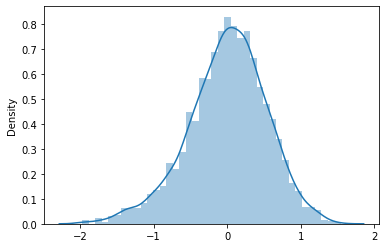

In [139]:
#Diagnostic
sns.distplot(model_1.resid)
plt.show()

#### Residual is following a normal distribution, which is a good sign.

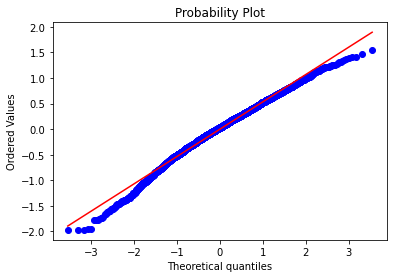

In [140]:
from scipy import stats
import pylab

stats.probplot(model_1.resid, dist = 'norm', plot = pylab)
pylab.show()

### Performing Decile Analysis

In [141]:
train['Deciles']=pd.qcut(train['pred'],10, labels=False)
train.head()

,income,othdebt,carcatvalue_3,creddebt,retire,inccat_4,carown,reason_2,carown_1,card_2,...,card2_4,pager,callwait,vote,internet_4,callid,confer,log_Total_spent,pred,Deciles
509,60.0,2.08,0,2.36,0.0,0,0,0,1,0,...,1,0.0,0.0,0.0,0,0.0,0.0,6.743953,6.528086,9
3847,191.0,10.78,1,7.74,0.0,0,0,0,1,1,...,0,0.0,1.0,0.0,0,1.0,1.0,6.419848,6.251176,7
3417,87.0,3.72,1,0.89,0.0,1,1,0,0,1,...,1,0.0,1.0,1.0,0,1.0,1.0,6.265206,5.982107,4
382,16.0,1.23,0,0.65,0.0,0,0,0,1,1,...,0,0.0,0.0,1.0,0,0.0,0.0,5.803266,5.588206,1
1345,32.0,3.99,0,1.07,0.0,0,1,0,0,1,...,0,0.0,1.0,0.0,0,1.0,1.0,6.743588,5.818511,3


In [142]:
test['Deciles']=pd.qcut(test['pred'],10, labels=False)
test.head()

,income,othdebt,carcatvalue_3,creddebt,retire,inccat_4,carown,reason_2,carown_1,card_2,...,card2_4,pager,callwait,vote,internet_4,callid,confer,log_Total_spent,pred,Deciles
3183,32.0,1.47,0,0.42,0.0,0,0,0,1,0,...,0,1.0,1.0,1.0,0,1.0,1.0,5.814578,5.735644,2
1071,43.0,2.66,0,2.50,0.0,0,0,0,0,0,...,0,0.0,1.0,1.0,0,1.0,0.0,6.485368,5.713551,1
2640,47.0,3.82,0,4.36,0.0,0,0,0,1,1,...,1,0.0,1.0,1.0,0,1.0,0.0,5.841746,5.899992,3
2282,42.0,2.32,0,0.62,0.0,0,0,0,1,0,...,1,0.0,1.0,0.0,1,1.0,1.0,6.017912,6.355161,8
1595,36.0,5.80,0,0.78,0.0,0,0,0,1,0,...,0,1.0,1.0,1.0,0,1.0,1.0,6.724950,6.005068,5


In [143]:
avg_actual = train[["Deciles", "log_Total_spent"]].groupby('Deciles').mean().sort_index(ascending = False)["log_Total_spent"]
avg_pred = train[["Deciles", "pred"]].groupby(train.Deciles).mean().sort_index(ascending = False)["pred"]

In [144]:
Decile_analysis_train = pd.concat([avg_pred, avg_actual], axis = 1)
Decile_analysis_train

,pred,log_Total_spent
Deciles,,
9,6.690872,6.692591
8,6.402390,6.434877
7,6.248421,6.229381
6,6.121494,6.104353
5,6.035577,5.996613
4,5.951772,5.994703
3,5.840811,5.815547
2,5.747994,5.754246
1,5.627345,5.677159


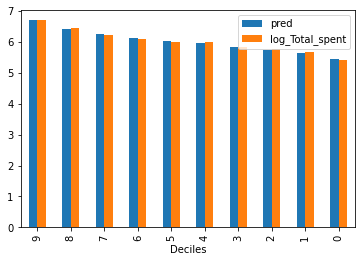

In [145]:
Decile_analysis_train.plot(kind = 'bar')
plt.show()

In [146]:
lift_chart = Decile_analysis_train.copy(deep = True)

lift_chart['lift_train_cum'] = np.round(((Decile_analysis_train['log_Total_spent'] / Decile_analysis_train['log_Total_spent'].sum()).cumsum()),4) * 100
lift_chart['lift_test_cum'] = np.round(((Decile_analysis_train['pred'] / Decile_analysis_train['pred'].sum()).cumsum()),4) * 100
lift_chart['Base %'] = [10,20,30,40,50,60,70,80,90,100]
lift_chart

,pred,log_Total_spent,lift_train_cum,lift_test_cum,Base %
Deciles,,,,,
9,6.690872,6.692591,11.13,11.13,10
8,6.402390,6.434877,21.84,21.78,20
7,6.248421,6.229381,32.20,32.17,30
6,6.121494,6.104353,42.35,42.35,40
5,6.035577,5.996613,52.32,52.39,50
4,5.951772,5.994703,62.30,62.29,60
3,5.840811,5.815547,71.97,72.01,70
2,5.747994,5.754246,81.54,81.57,80
1,5.627345,5.677159,90.98,90.93,90


In [147]:
lift_chart['lift_train_lift'] = (lift_chart['lift_train_cum']/lift_chart['Base %'])
lift_chart['lift_test_lift'] = (lift_chart['lift_test_cum']/lift_chart['Base %'])
lift_chart['Baseline']  = [1,1,1,1,1,1,1,1,1,1]
lift_chart = lift_chart[['lift_train_lift', 'lift_test_lift', 'Baseline']]
lift_chart

,lift_train_lift,lift_test_lift,Baseline
Deciles,,,
9,1.113000,1.113000,1
8,1.092000,1.089000,1
7,1.073333,1.072333,1
6,1.058750,1.058750,1
5,1.046400,1.047800,1
4,1.038333,1.038167,1
3,1.028143,1.028714,1
2,1.019250,1.019625,1
1,1.010889,1.010333,1


(0.0, 2.0)

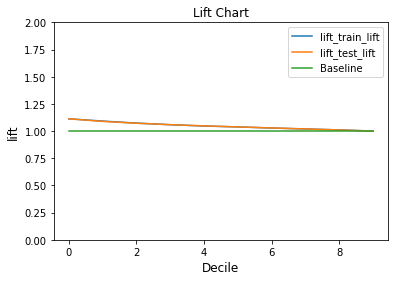

In [148]:
lift_chart = lift_chart.plot(kind='line',use_index=False)
lift_chart.set_ylabel("lift",fontsize=12)
lift_chart.set_xlabel("Decile",fontsize=12)
lift_chart.set_title("Lift Chart")
lift_chart.set_ylim(0.0,2)

In [149]:
#### Lets save everything in metrics_df to pickle object
import pickle

# now you can save it to a file
with open('model_Linear_reg.pkl', 'wb') as f:
    pickle.dump(model, f)

In [150]:
# and later you can load it
with open('model_Linear_reg.pkl', 'rb') as f:
    model_new = pickle.load(f)

In [151]:
model_new.predict(test)

3183    5.764040
1071    5.833586
2640    5.948869
2282    6.437309
1595    6.050171
          ...   
1743    5.907738
3269    5.832556
4160    5.414838
2704    5.527247
913     6.712997
Length: 1500, dtype: float64